## Generative Adversarial Nets

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

Target distribution $p_{data}$

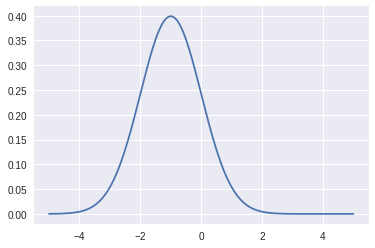

In [5]:
mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))
#plt.savefig('fig0.png')

In [7]:
TRAIN_ITERS=10000
M=200 # minibatch size

In [8]:
# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [9]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

### Pre-train Decision Surface
If decider is reasonably accurate to start, we get much faster convergence.

In [10]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))


In [11]:
optimizer=momentum_optimizer(loss,None)

In [12]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [13]:
# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(r/M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()